#### Imports 

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import time
import datetime
import numpy as np

import matplotlib.pyplot as plt

def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

In [ ]:
from sentinelhub import MimeType, CRS
from sentinelhub.sentinelhub_client import SentinelHubClient
import sentinelhub.sentinelhub_request as shr

evalscript = """
    function setup() {
        return {
            input: ["B02", "B03", "B04"],
            output: { bands: 3 }
        };
    }

    function evaluatePixel(sample) {
        return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
"""

def get_images():
    sh_request = shr.body(
        request_bounds=shr.bounds(crs=CRS.WGS84.opengis_string, bbox=[46.16, -16.15, 46.51, -15.58]),
        request_data=[shr.data(data_type='S2L1C')],
        request_output=shr.output(size_x=512, size_y=856, responses=[shr.response('default', 'image/tiff')]),
        evalscript=evalscript
    )
    client = SentinelHubClient()  # The following is ATM out of date
    return client.get_time_range(sh_request, time_range=('2017-12-15', '2017-12-30'))

In [ ]:
start_time = time.time()
images = get_images()
print("--- %s seconds ---" % (time.time() - start_time))

In [4]:
len(images)

4

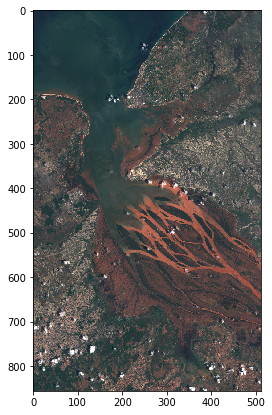

In [5]:
plot_image(images[3])

## ApiRequest

### Making a single request

In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import time
import datetime
import numpy as np

import matplotlib.pyplot as plt

def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)


from sentinelhub import ApiRequest, BBox, CRS, MimeType, DataSourceParam, DataSource

bbox = BBox([46.16, -16.15, 46.51, -15.58], CRS.WGS84)

evalscript = """
    function setup() {
        return {
            input: ["B02", "B03", "B04"],
            output: { bands: 3 }
        };
    }

    function evaluatePixel(sample) {
        return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
    }
"""


api_request = ApiRequest(
    evalscript, bbox=bbox, width=512, height=856,
    input_data=[
        {
            DataSourceParam.TYPE: DataSource.SENTINEL2_L1C,
            DataSourceParam.TIME_RANGE: ('2017-12-15', '2017-12-30'),
            DataSourceParam.UPSAMPLING: 'NEAREST',
            DataSourceParam.MAX_CLOUD_COVERAGE: 50
        }
    ],
    output_responses=[MimeType.TIFF, MimeType.PNG]
)

api_request.download_request.post_values

{'input': {'bounds': {'properties': {'crs': 'http://www.opengis.net/def/crs/EPSG/0/4326'},
   'bbox': [46.16, -16.15, 46.51, -15.58]},
  'data': [{'type': 'S2L1C',
    'dataFilter': {'timeRange': {'from': '2017-12-15T00:00:00Z',
      'to': '2017-12-30T23:59:59Z'},
     'maxCloudCoverage': 50},
    'processing': {'upsampling': 'NEAREST'}}]},
 'evalscript': '\n    function setup() {\n        return {\n            input: ["B02", "B03", "B04"],\n            output: { bands: 3 }\n        };\n    }\n\n    function evaluatePixel(sample) {\n        return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];\n    }\n',
 'output': {'responses': [{'format': {'type': 'image/tiff'},
    'identifier': 'default'},
   {'format': {'type': 'image/png'}, 'identifier': 'default'}],
  'width': 512,
  'height': 856}}

In [16]:
output = api_request.get_data(redownload=True)
output.keys()

dict_keys(['default.tif', 'default.png'])

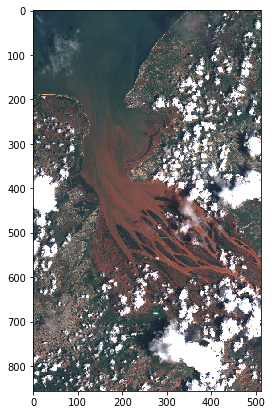

In [17]:
plot_image(output['default.png'])

### Making multiple requests and downloading them in parallel

In [6]:
from sentinelhub import SentinelHubDownloadClient

download_list = []

for time_range in [('2017-12-15', '2017-12-30'), ('2018-12-15', '2018-12-30')]:
    api_request = ApiRequest(
        evalscript, bbox=bbox, width=512, height=856,
        input_data=[
            {
                DataSourceParam.TYPE: DataSource.SENTINEL2_L1C,
                DataSourceParam.TIME_RANGE: time_range,
                DataSourceParam.MAX_CLOUD_COVERAGE: 50,
                DataSourceParam.UPSAMPLING: 'NEAREST'
            }
        ],
        output_responses=[MimeType.TIFF, MimeType.PNG]
    )
    
    download_list.append(api_request.download_request)
    
results = SentinelHubDownloadClient().download_data(download_list)

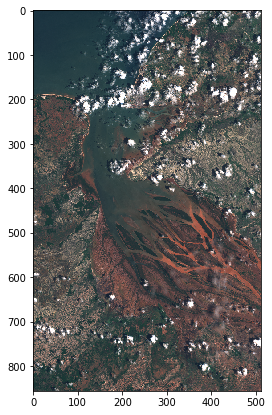

In [7]:
plot_image(results[1]['default.tif'])

### Parameters can also be specificed more according to API specifications

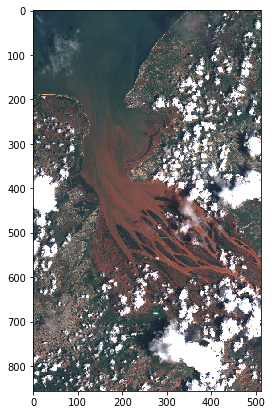

In [18]:
api_request = ApiRequest(
    evalscript, bbox=bbox, width=512, height=856,
    input_data=[
        {
            'type': 'S2L1C',
            'dataFilter': {
                'timeRange': {
                    'from': '2017-12-15T00:00:00Z',
                    'to': '2017-12-30T23:59:59Z'
                },
                'maxCloudCoverage': 50
            },
            'processing': {
                'upsampling': 'NEAREST'
            }
        }
    ],
    output_responses=[
        {
            'identifier': 'default',
            'format': {
                'type': 'png'
            }
        },
        {
            'identifier': 'default',
            'format': {
                'type': 'tiff'
            }
        }
    ]
)

result = api_request.get_data(redownload=True)
plot_image(output['default.png'])